In [46]:
import os
import math, pandas as pd
from math import exp
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from openai import OpenAI

In [2]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [ ]:
concepts = []

In [13]:
response = client.responses.create(
    model="gpt-4o-mini",
    input="Write a one-sentence bedtime story about a unicorn.",
    top_logprobs=5,  # how many alternatives per position
    include=["message.output_text.logprobs"]  # tell the API to return them
)

In [14]:
# The first message's first text part:
part = response.output[0].content[0]

In [36]:
text = response.output[0].content[0].text
text

'As the moonlight danced on the forest floor, a gentle unicorn named Lila spread her shimmering wings and soared through the starlit skies, painting dreams of magic and wonder for all the sleeping children below.'

In [17]:
def get_text_part(resp, msg_idx=0, part_idx=0):
    """Grab the first text chunk from the Responses API object."""
    return resp.output[msg_idx].content[part_idx]

def build_topk_tables(resp, k=5, msg_idx=0, part_idx=0):
    """
    Returns (wide_df, long_df)

    wide_df columns:
      i, emitted_token, emitted_p, alt1_token, alt1_p, ..., altk_token, altk_p

    long_df columns:
      i, rank (0 = emitted), token, p
    """
    part = get_text_part(resp, msg_idx, part_idx)
    rows_wide = []
    rows_long = []

    for i, t in enumerate(part.logprobs):
        emitted_tok = t.token
        emitted_p   = math.exp(t.logprob)

        # Collect candidates from top_logprobs (already the model's best guesses)
        alts_raw = getattr(t, "top_logprobs", []) or []
        # Convert to (token, p) and sort by p desc just in case
        alts = [(a.token, math.exp(a.logprob)) for a in alts_raw]
        alts.sort(key=lambda x: x[1], reverse=True)

        # Ensure emitted token appears as rank 0 in long-form, even if it's not in alts
        rows_long.append({"i": i, "rank": 0, "token": emitted_tok, "p": emitted_p})

        # Keep top k alternatives (exclude emitted if it happens to be duplicated in alts)
        topk = []
        for tok, p in alts:
            if tok == emitted_tok and abs(p - emitted_p) < 1e-12:
                continue
            topk.append((tok, p))
            if len(topk) >= k:
                break

        # Add alternatives to long-form with ranks 1..k
        for r, (tok, p) in enumerate(topk, start=1):
            rows_long.append({"i": i, "rank": r, "token": tok, "p": p})

        # Build wide-row
        wide_row = {
            "i": i,
            "emitted_token": emitted_tok,
            "emitted_p": emitted_p,
        }
        for j in range(k):
            tokj, pj = (topk[j] if j < len(topk) else ("", float("nan")))
            wide_row[f"alt{j+1}_token"] = tokj
            wide_row[f"alt{j+1}_p"] = pj
        rows_wide.append(wide_row)

    wide_df = pd.DataFrame(rows_wide)
    long_df = pd.DataFrame(rows_long)
    return wide_df, long_df

In [23]:
wide, long = build_topk_tables(response, k=5)
wide.head()   # emitted + top-5 (wide form)
long.head(10) # first few positions, ranks 0..5 (long form)

,i,rank,token,p
0,0,0,As,0.823894
1,0,1,Under,0.086838
2,0,2,Once,0.052670
3,0,3,In,0.031946
4,0,4,Every,0.002622
5,1,0,the,0.997541
6,1,1,twilight,0.002182
7,1,2,Luna,0.000096
8,1,3,tw,0.000035
9,1,4,dusk,0.000031


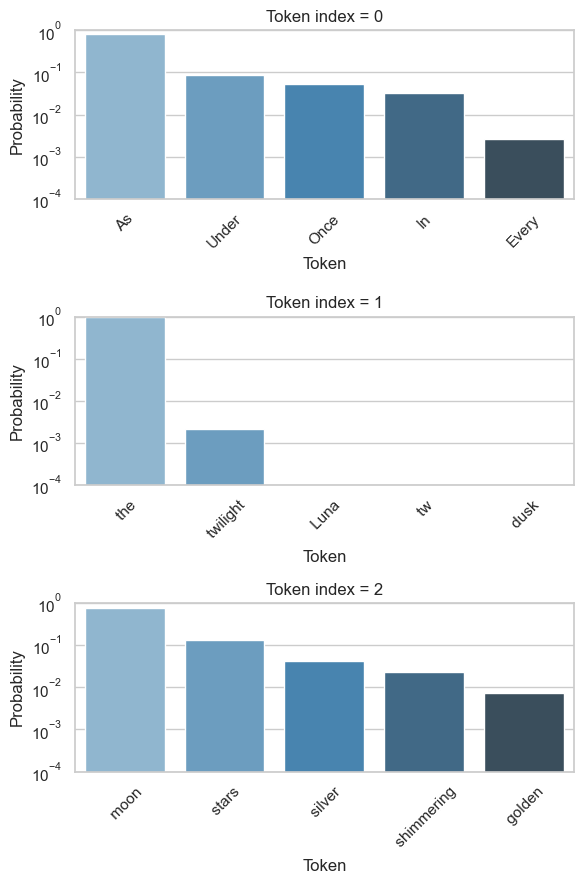

In [43]:
df = long.head(15)

sns.set(style="whitegrid")

groups = df['i'].unique()
n_groups = len(groups)

fig, axes = plt.subplots(n_groups, 1, figsize=(6, 3 * n_groups), sharex=False)

if n_groups == 1:
    axes = [axes]

for ax, i_val in zip(axes, groups):
    subset = df[df['i'] == i_val]
    sns.barplot(
        data=subset,
        x='token',
        y='p',
        hue='token',        # assign x variable to hue
        dodge=False,        # ensures bars don’t shift
        legend=False,       # no legend (since hue = token)
        palette='Blues_d',
        ax=ax
    )
    ax.set_title(f'Token index = {i_val}', fontsize=12)
    ax.set_xlabel('Token')
    ax.set_ylabel('Probability')
    ax.set_yscale('log')
    ax.set_ylim(1e-4, 1) 
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

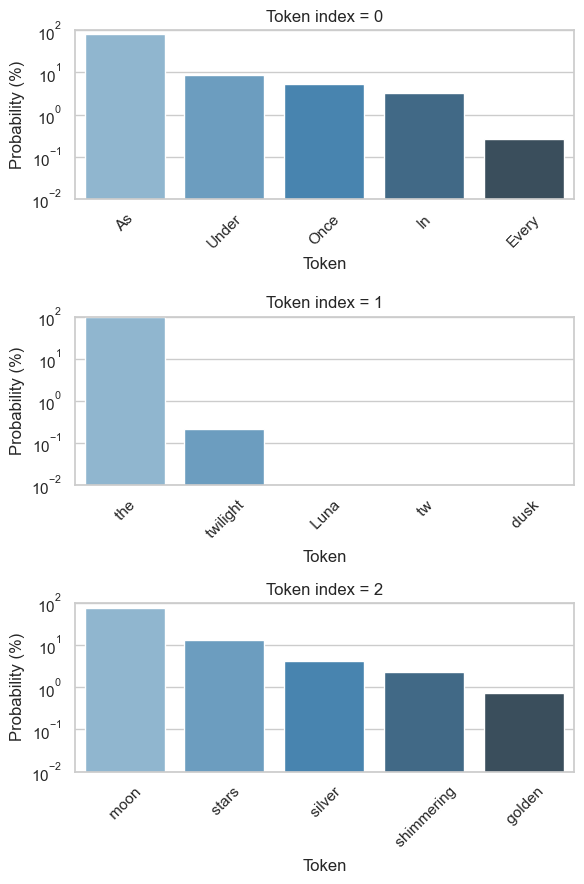

In [44]:
df = long.head(15)

sns.set(style="whitegrid")

groups = df['i'].unique()
n_groups = len(groups)

fig, axes = plt.subplots(n_groups, 1, figsize=(6, 3 * n_groups), sharex=False)

if n_groups == 1:
    axes = [axes]

for ax, i_val in zip(axes, groups):
    subset = df[df['i'] == i_val].copy()
    subset['p'] = subset['p'] * 100  # convert to percentage

    sns.barplot(
        data=subset,
        x='token',
        y='p',
        hue='token',
        dodge=False,
        legend=False,
        palette='Blues_d',
        ax=ax
    )

    ax.set_title(f'Token index = {i_val}', fontsize=12)
    ax.set_xlabel('Token')
    ax.set_ylabel('Probability (%)')
    ax.set_yscale('log')
    ax.set_ylim(1e-2, 100)  # adjust for percentages (avoid 0 on log scale)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()